In [1]:
import numpy as np
import sys
sys.path.append('../')
from symmetry_breaking_measure import FiniteCluster, TranslationOperator
import matplotlib.pyplot as plt
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
from colour import Color
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.image import imread
from matplotlib import rc
import pandas as pd
from tqdm import tqdm
from typing import Tuple
from symmetry_breaking_measure.constants import (
    NICKEL_LATTICE,
    NICKEL_NUM_ELECTRON,
    NICKEL_UISO,
)
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

BLUE, RED, YELLOW, MIDDLE = '#0B3C5D', '#B82601', '#D9B310', '#a8b6c1'

NUM_SAMPLES = 50000
CONFIDENCE_LEVEL = .95
TOLERANCE_ONE_SIDE = .0025

In [2]:
def get_original_atom(uiso):
    original_atom = FiniteCluster(atoms_info=pd.DataFrame([[0, 0, 0, 1, uiso, 1.0]],
                        columns=["x", "y", "z", "num_electrons", "uiso", "occupancy"]))
    return original_atom

def calc_variance_sample_size_from_nickel(original_atom, disp):
    sample_size, measure = original_atom.calc_symmetry_breaking_measure_sample_size(
        num_samples=NUM_SAMPLES,
        operator=TranslationOperator(direction=[0,0,1], displacement=disp),
        confidence_interval=CONFIDENCE_LEVEL,
        tolerance_single_side=TOLERANCE_ONE_SIDE,
        method='JS',
        )
    return measure, sample_size

def compute_sbm(uiso, disp):
    original_atom = get_original_atom(uiso)
    _, sample_size = calc_variance_sample_size_from_nickel(original_atom, disp)
    num_samples = [max(int(sample_size[1]), 3000), max(int(sample_size[2]), 3000)]
    measure = original_atom.calc_symmetry_breaking_measure(num_samples=num_samples, 
                                                           operator=TranslationOperator(direction=[0,0,1], displacement=disp), 
                                                           method='JS') 
    return measure

uiso: 0.005, d: 0.8743718592964824, d/sqrt(uiso): 12.365485419744651, d^2/uiso: 152.90522966591752, measure: 0.9905861945270118
uiso: 0.01, d: 1.0552763819095476, d/sqrt(uiso): 10.552763819095476, d^2/uiso: 111.36082422161056, measure: 0.990508328738597
uiso: 0.02, d: 1.2864321608040201, d/sqrt(uiso): 9.096449044409859, d^2/uiso: 82.745385217545, measure: 0.9907095642734345
uiso: 0.03, d: 1.4472361809045227, d/sqrt(uiso): 8.355621986261921, d^2/uiso: 69.81641877730361, measure: 0.9905805159266741
uiso: 0.04, d: 1.5778894472361809, d/sqrt(uiso): 7.889447236180904, d^2/uiso: 62.243377692482504, measure: 0.9905092123479399


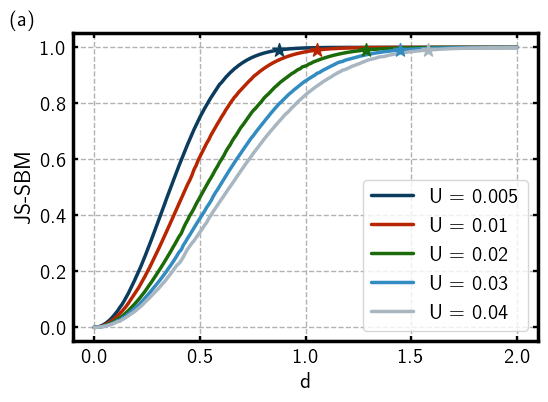

In [12]:
import numpy as np
import matplotlib.pyplot as plt
# Parameters
uiso_values = [0.005, 0.01, 0.02, 0.03, 0.04]
disp_values = np.linspace(0, 2, 200)

# Plotting
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
rc('text', usetex = True) 
params= {'text.latex.preamble' : r'\usepackage{mathrsfs}'}
plt.rcParams.update(params)
plt.style.use(bg_mpl_style)

for uiso in uiso_values:
    measures = [compute_sbm(uiso, disp) for disp in disp_values]
    ax.plot(disp_values, measures, label=f'U = {uiso}')
    # Determine the point where measure reaches 0.95
    for i, measure in enumerate(measures):
        if measure >= 0.99:
            ax.scatter(disp_values[i], measure, marker='*', s=100, zorder=3)
            print(f"uiso: {uiso}, d: {disp_values[i]}, d/sqrt(uiso): {disp_values[i]/np.sqrt(uiso)}, d^2/uiso: {disp_values[i]**2/uiso}, measure: {measure}")
            break

ax.legend()
ax_text = fig.add_axes([0.02, .9, 0, 0])
ax_text.text(0, 0, '(a)')
ax_text.set_axis_off()

ax.set_xlabel('d')
ax.set_ylabel('JS-SBM')
#ax.set_ylabel(r'$\mathscr{S}^{JS}[\mu \| T_{d}[\mu]]$')
#plt.title('SBM Measure vs. Dispersion for Different Uiso')
ax.grid(True)

plt.show()
fig.savefig('../figs/two_atom.png')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
uiso_values = np.linspace(0.005, 0.04, 50)
disp_values = np.linspace(0, 2, 200)
# Data storage for plotting
threshold_ds = []

for uiso in tqdm(uiso_values):
    found = False  # Flag to indicate if the threshold has been found
    for disp in disp_values:
        measure = compute_sbm(uiso, disp)
        if measure >= 0.99:
            threshold_ds.append(disp)
            found = True
            break
            
    if not found:
        threshold_ds.append(None)  # Append None if no threshold was found

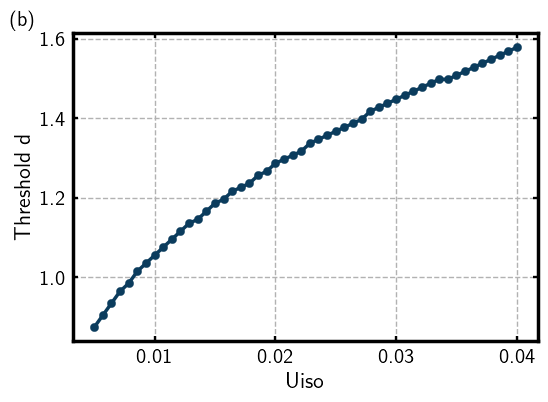

In [42]:
# Plotting setup
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
rc('text', usetex = True) 
params= {'text.latex.preamble' : r'\usepackage{mathrsfs}'}
plt.rcParams.update(params)
plt.style.use(bg_mpl_style)

ax_text = fig.add_axes([0.02, .9, 0, 0])
ax_text.text(0, 0, '(b)')
ax_text.set_axis_off()
        
# Plotting threshold d vs uiso
ax.plot(uiso_values, threshold_ds, marker='o', linestyle='-')
ax.set_xlabel('Uiso')
ax.set_ylabel('Threshold d')
ax.grid(True)
plt.show()
fig.savefig('../figs/two_atom2.png')

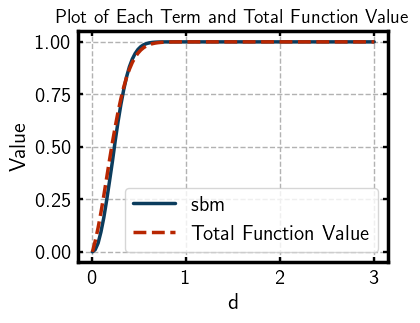

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

# Constants
U = 0.013
d_values = np.linspace(0, 3, 100)
sample_size = 50000

# Updated Monte Carlo simulation function using base 2 log
def monte_carlo_integral_base2(d, U, sign):
    samples = np.random.normal(0, np.sqrt(U), sample_size)
    values = np.log2(1 + np.exp(-np.abs((d / U) * samples - sign * (d**2 / (2 * U)))))
    return -0.5 * np.mean(values)

# Updated direct calculation function with base 2 log
def calculate_direct_base2(d, U):
    term1 = (d**2) / (2 * U) * (1 - norm.cdf(d / (2 * np.sqrt(U))))
    term2 = (d / np.sqrt(U)) * norm.pdf(d / (2 * np.sqrt(U)))
    return term1 - term2 + 1  # Using 1 as np.log2(2) simplification

# Arrays to store values of each term
function_values = []
total_function_values = []

# Calculate the values for each term
for d in d_values:
    term1 = monte_carlo_integral_base2(d, U, -1)
    term2 = monte_carlo_integral_base2(d, U, 1)
    term3 = calculate_direct_base2(d, U)
    total = term1 + term2 + term3
    total_function_values.append(total)
    f = compute_sbm(U, 2*d)
    function_values.append(f)

# Plotting
plt.figure(figsize=(4, 3))
plt.plot(d_values, function_values, label="sbm")
plt.plot(d_values, total_function_values, label="Total Function Value", linestyle='--')
plt.xlabel("d")
plt.ylabel("Value")
plt.title("Plot of Each Term and Total Function Value")
plt.legend()
plt.grid(True)
plt.show()
